# PCA & Clustering
---

In [35]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap

import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
# func 모음

# 1. 종목코드를 6자리로 통일. ex) 990 -> 000990
def padding(x):
    return x.rjust(6, "0")

---
# 1. PCA

## 1-1. Data

In [20]:
df = pd.read_csv("./datasets/preprocessed_final.csv", index_col=0)
df["종목코드"] = df["종목코드"].astype("str")
df["종목코드"] = df["종목코드"].map(padding)
df

,종목코드,회사명,NCAV,PEGR,PSR,유동비율,부채비율,일일변동평균,샤프지수,종목명,PER,PBR,시가총액
0,000990,(주)DB하이텍,0.028653,4.113681,2.670785,174.09,48.29,0.445142,49.648820,DB하이텍,23.36,3.89,2499641.0
1,023150,(주)MH에탄올,-0.301897,-0.000000,1.253321,117.69,69.27,0.081587,1.717932,MH에탄올,0.00,1.12,64267.0
2,002360,(주)SH에너지화학,0.361237,-0.000000,1.143522,917.82,29.79,0.166757,10.246872,SH에너지화학,0.00,1.07,104466.0
3,009160,(주)SIMPAC,0.176695,-0.571031,0.779131,125.85,51.22,0.174309,27.341287,SIMPAC,20.64,0.48,211992.0
4,100840,(주)SNT에너지,0.779873,0.073893,0.577712,257.09,40.37,0.131054,21.178235,SNT에너지,8.24,0.54,132869.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
841,000850,화천기공(주),0.763649,7.384076,0.567872,341.83,24.95,0.077436,17.755082,화천기공,10.23,0.26,76230.0
842,016580,환인제약(주),0.537149,3.277122,1.954171,798.20,11.09,0.105514,11.548340,환인제약,14.69,1.22,334801.0
843,094280,효성아이티엑스(주),-0.235806,1.557279,0.485197,63.82,227.69,0.222635,21.623614,효성ITX,22.47,4.85,233476.0
844,205470,휴마시스(주),0.099311,-0.000000,4.392172,439.90,39.94,0.530306,16.946579,휴마시스,0.00,12.50,231353.0


In [21]:
## PCA를 위한 데이터 구분 / 수치형 변수들로만 구성된 data로 PCA 수행
df_obj = df.select_dtypes(include='object')
df_num = df.select_dtypes(exclude='object')

# column에 PCA를 적용하기 이전에 scaling을 진행 / eigenvalue를 확인
scaler = StandardScaler()
scaled_ds = pd.DataFrame(scaler.fit_transform(df_num), columns=df_num.columns)
scaled_ds.head()

,NCAV,PEGR,PSR,유동비율,부채비율,일일변동평균,샤프지수,PER,PBR,시가총액
0,0.096924,0.987483,-0.115637,-0.333705,-0.356493,0.857063,1.083739,-0.140511,0.903997,0.025080
1,-0.483167,0.135456,-0.292114,-0.515496,-0.048657,-1.162791,-1.229959,-0.401798,-0.370938,-0.112188
2,0.680584,0.135456,-0.305784,2.063518,-0.627940,-0.689599,-0.818254,-0.401798,-0.393951,-0.109923
3,0.356727,0.017184,-0.351151,-0.489194,-0.313501,-0.647641,0.006920,-0.170935,-0.665508,-0.103862
4,1.415260,0.150761,-0.376228,-0.066176,-0.472702,-0.887961,-0.290580,-0.309631,-0.637892,-0.108322


## 1-2. 주성분 설명력 확인

In [60]:
df_pca = pd.DataFrame((eigen_vals/tot), index=scaled_ds.columns, columns=["설명력"])
df_pca.sort_values(by=["설명력"])
df_pca

,설명력
NCAV,0.211058
PEGR,0.193316
PSR,0.131347
유동비율,0.119815
부채비율,0.099576
일일변동평균,0.082657
샤프지수,0.016518
PER,0.035819
PBR,0.056520
시가총액,0.053373


/var/folders/x3/lny9bbwx64b561c29r4y4z400000gn/T/ipykernel_71764/3091184214.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


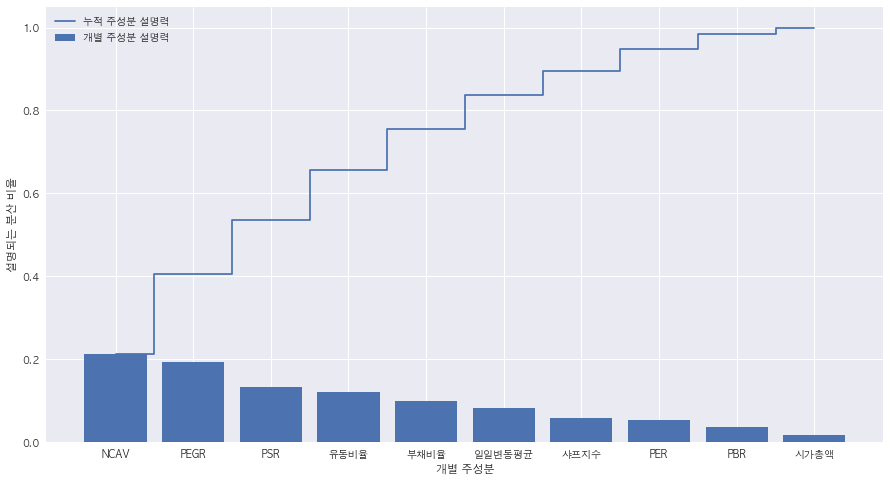

In [94]:
# PCA로 설명되는 분산을 계산 & plot
import matplotlib.pyplot as plt
import warnings
%matplotlib inline
plt.style.use('seaborn')
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.family"] = "AppleGothic"
plt.rcParams['figure.figsize'] = [15, 8]

cov_mat = np.cov(scaled_ds.T) # 각 열에 대해 공분산 계산
eigen_vals, _ = np.linalg.eig(cov_mat) # 공분산의 고유값, 고유벡터 계산. (PCA에서의 분산 = 고유값)
tot=sum(eigen_vals) 

var_exp=[(i/tot) for i in sorted(eigen_vals,reverse=True)] # 개별 주성분 설명력(고유값 / 전체 고유값). 공분산의 고유값이 높은 순서대로 계산(%)
cum_var_exp=np.cumsum(var_exp) # 누적 주성분 설명력

plt.bar(scaled_ds.columns, var_exp, label='개별 주성분 설명력')
plt.step(scaled_ds.columns,cum_var_exp, where='mid', label='누적 주성분 설명력')
plt.ylabel('설명되는 분산 비율')
plt.xlabel('개별 주성분')
plt.legend(loc='best')

In [75]:
# 주성분별 설명력 & 누적 설명력
## 6개 이상일 때 누적설명력이 0.8을 넘음
data = {"설명력":list(eigen_vals/tot), "누적설명력": list(cum_var_exp)}
df_pca = pd.DataFrame(data, index=scaled_ds.columns)
df_pca.sort_values(by=["설명력"])
df_pca

,설명력,누적설명력
NCAV,0.211058,0.211058
PEGR,0.193316,0.404374
PSR,0.131347,0.535721
유동비율,0.119815,0.655536
부채비율,0.099576,0.755112
일일변동평균,0.082657,0.837769
샤프지수,0.016518,0.894289
PER,0.035819,0.947663
PBR,0.056520,0.983482
시가총액,0.053373,1.000000


In [100]:
# 분산 80%이상을 설명하는 주성분 갯수( = PCA 차원 수)
pca = PCA()
pca.fit(scaled_ds)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.80) + 1
d

6

## 1-3. PCA : 차원축소

In [117]:
# 분산 누적 설명량이 80% 이상 도달하는 6차원으로 축소
pca = PCA(n_components=6, random_state=100)
PCA_ds = pd.DataFrame(pca.fit_transform(scaled_ds), columns=(['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6']))
PCA_ds

,PC1,PC2,PC3,PC4,PC5,PC6
0,0.516872,1.324843,-1.027027,-0.026448,0.130861,-0.828635
1,-0.257663,-1.852913,-0.116521,0.285218,0.013938,-0.073991
2,-2.120629,-0.383344,-0.177704,-0.461681,-0.106295,0.277792
3,-0.313063,-0.696681,0.034869,-0.568150,0.181508,-0.119855
4,-1.315988,-0.660653,-0.086664,-0.726747,0.234847,-0.380863
...,...,...,...,...,...,...
841,-1.761517,-0.937878,-1.129403,-0.484312,0.256418,-0.755439
842,-2.372281,-0.466153,-0.555015,-0.229212,-0.012281,-0.160575
843,1.639205,-0.731900,-0.454511,1.121086,-0.287934,-1.009442
844,-0.186825,2.405234,-0.885518,2.294603,-0.496585,-2.329335


## 1-4. PCA 주성분과 변수들의 상관관계

In [ ]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
# loadings.shape
loading_matrix = pd.DataFrame(loadings, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'],
                            index=scaled_ds.columns)

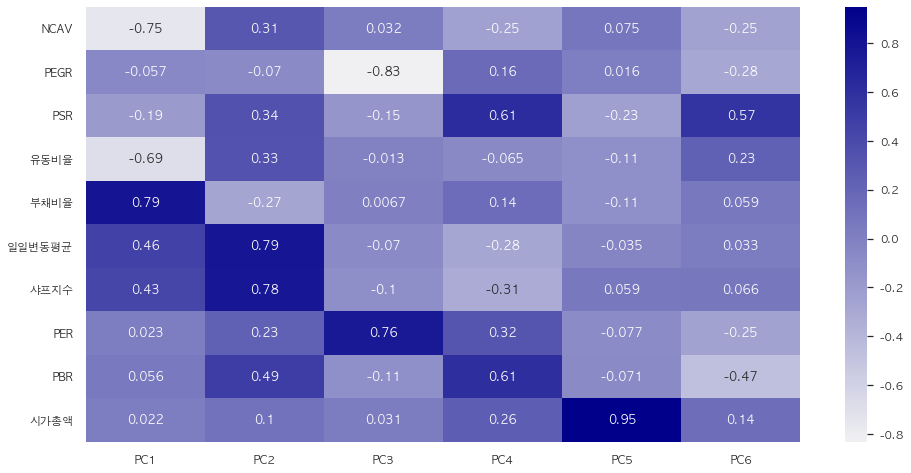

In [ ]:
cmap = sns.light_palette("DarkBlue", as_cmap = True)
sns.set(font="AppleGothic",rc = {'figure.figsize':(16,8)})  
sns.heatmap(loading_matrix, annot = True, cmap = cmap)
plt.show()

---
# 2. 클러스터링

## 2-1. Elbow Method : 클러스터 k 결정
- 파란색 : 각 데이터들의 군집 중심과의 평균 거리
- 초록색 : 학습 시간

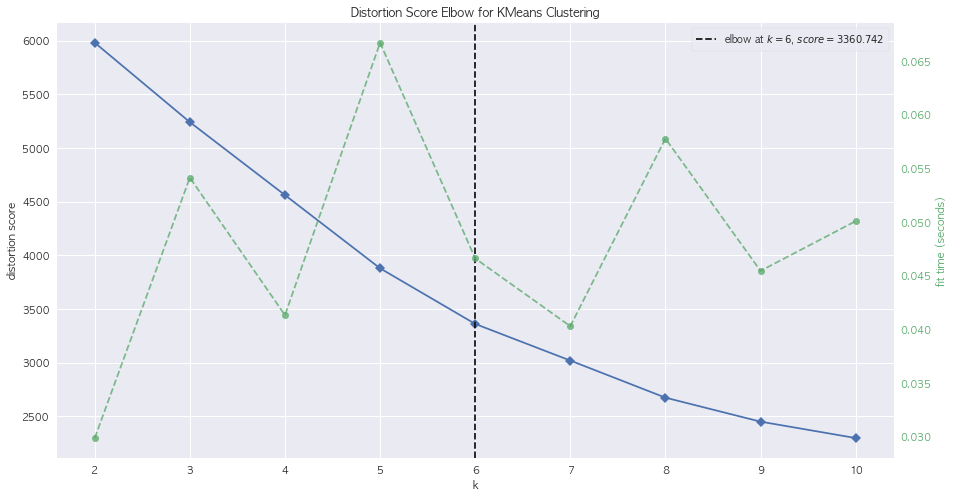

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [104]:
# distortion score : 각 클러스터 중심으로부터 데이터간의 거리의 제곱합
Elbow_M = KElbowVisualizer(KMeans(random_state = 100), k=10, metric = 'distortion') 
Elbow_M.fit(PCA_ds)
Elbow_M.show()

In [124]:
np.random.seed(42)
AC = AgglomerativeClustering(n_clusters=5, linkage='ward')
# fit model and predict clusters
yhat_AC = AC.fit_predict(PCA_ds)
PCA_ds["Clusters"] = yhat_AC

# Adding the Clusters feature to the orignal dataframe.
df["Clusters"]= yhat_AC

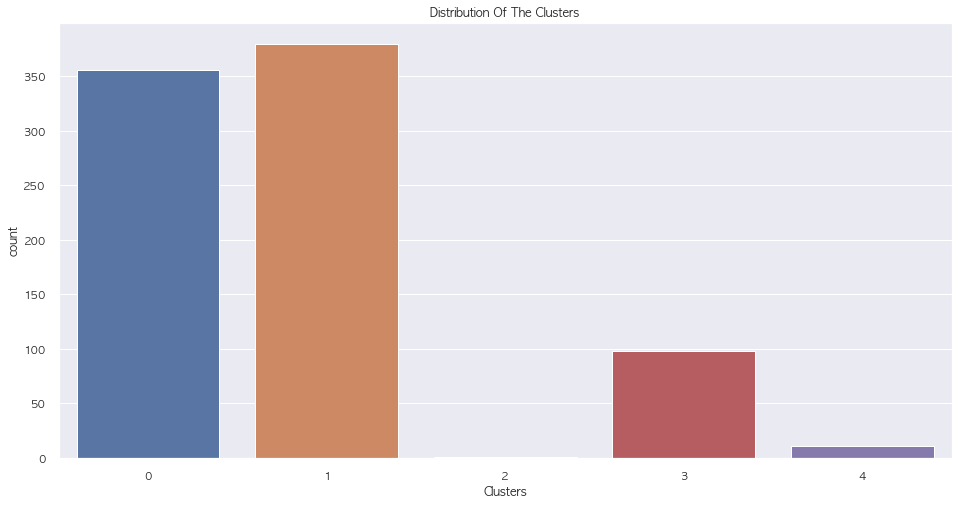

In [125]:
#Plotting countplot of clusters
pl = sns.countplot(x=df["Clusters"])
pl.set_title("Distribution Of The Clusters")
plt.show()

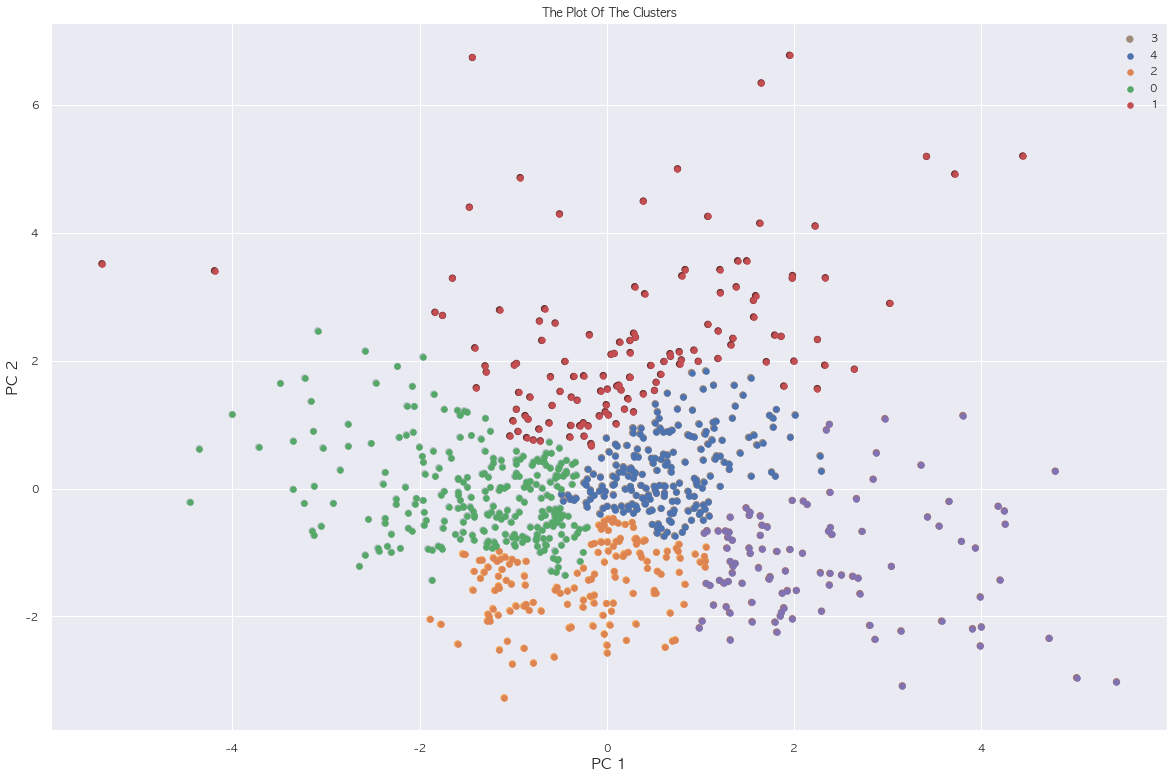

In [126]:
# Plotting the clusters / A 2D Projection Of Data In The Reduced Dimension
from matplotlib import colors
import matplotlib.font_manager as fm
import seaborn as sns
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])

labels = PCA_ds2["Clusters"].unique().tolist()
colors = ["#7fc97f","#beaed4","#fdc086","#ffff99","#666666"]

x =PCA_ds2["PC1"]; y =PCA_ds2["PC2"]
ig = plt.figure(figsize=(20,13))
ax = plt.subplot(111)
ax.scatter(x, y, s=40, c=PCA_ds2["Clusters"], marker='o', cmap = cmap)
ax.set_xlabel('PC 1', fontsize = 15)
ax.set_ylabel('PC 2', fontsize = 15)
ax.set_title("The Plot Of The Clusters")

for label, color in zip(labels, colors):
    indicesToKeep = (PCA_ds2['Clusters'] == label)
    ax.scatter(PCA_ds2.loc[indicesToKeep, 'PC1']
               , PCA_ds2.loc[indicesToKeep, 'PC2']
#                , c = color
               , s = 30)

plt.legend(labels)
plt.show()

In [127]:
# Plotting the clusters / A 3D Projection Of Data In The Reduced Dimension
labels = PCA_ds2["Clusters"].unique().tolist()
colors = ["#7fc97f","#beaed4","#fdc086","#ffff99","#666666"]

x =PCA_ds2["PC1"]; y =PCA_ds2["PC2"]; z =PCA_ds2["PC3"]
fig = plt.figure(figsize=(20,13))
ax = plt.subplot(111, projection='3d')
ax.set_xlabel('PC 1', fontsize = 15)
ax.set_ylabel('PC 2', fontsize = 15)
ax.set_zlabel('PC 3', fontsize = 15)
ax.set_title("The Plot Of The Clusters")

for label, color in zip(labels, colors):
    indicesToKeep = (PCA_ds2['Clusters'] == label)
    ax.scatter(PCA_ds2.loc[indicesToKeep, 'PC1']
               , PCA_ds2.loc[indicesToKeep, 'PC2']
               , PCA_ds2.loc[indicesToKeep, 'PC3']
#                , c = color
               , s = 30)

plt.legend(labels)
plt.show()

KeyError: 'PC3'